<a href="https://colab.research.google.com/github/belanatal/PosPUCRio/blob/main/MVPSprintIIb_IsabelaNatal-vers%C3%A3o3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PUC Rio: Pós Graduação em Ciência de Dados e Analytics**

**MVP Sprint II: Machine Learning & Analytics (40530010056_20230_01)**
**- Parte b**

Aluna: Isabela Fernanda Natal Batista Abreu Gomes

Julho/2023

## Seção I: Introdução
**Classificador de imagens multiclasse - Paisagens Naturais**

**Contexto:** O presente trabalho tem como objetivo criar um modelo de visão computacional baseado em Aprendizado de Máquina Profundo que seja capaz de classificar uma imagem segundo uma das 6 seguintes categorias de paisagens: Prédio; Floresta; Montanha; Geleira; Rua; Mar. Os dados/imagens foram baixados da plataforma Kaggle (Para mais informações "Scene Classification": https://www.kaggle.com/datasets/nitishabharathi/scene-classification).

**Estrutura:** O notebook encontra-se dividido da seguinte forma:

- Importação das bibliotecas
- Acesso e tratamento dos dados que serão a entrada do modelo de deep learning
- Configuração do modelo de deep learning usando uma rede neural convolucional simples com Keras
- Treinamento do modelo de deep learning
- Execução do modelo de deep learning treinado
- Avaliação do modelo de deep learning
- Exportação do modelo de deep learning
- Teste do modelo exportado

### Importando as bibliotecas necessárias para executar o notebook
(Serão utilizadas as bibliotecas pandas e numpy, para a manipulação dos dados; matplotlib, para geração de gráficos; os, para manipulação de pastas e diretórios e bibliotecas voltadas para Machine e Deep Learning, tais como Keras, Tensor Flow e Scikit-Learn)

In [51]:
!pip install tensorflow==2.13
!pip install keras

In [52]:
# Primeiro bloco: Importação das bibliotecas e módulos
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")
#
import os
import cv2 # Visão computacional para análise em imagens
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn.metrics as skm
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.optimizers import Adam
from IPython.display import Image, display
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#
#Para utilizar o upload e download de arquivos no colab:
from google.colab import drive
from google.colab import files
import gdown
from zipfile import ZipFile

### Acessando os dados que serão entrada do modelo - via Google Drive

In [53]:
# Baixando a pasta compactada para o notebook
folder_path = "https://drive.usercontent.google.com/download?id=11PLDr83xGsG-lxZMxoFadgEy-iR3q4Qq&export=download&authuser=0&confirm=t&uuid=35044ed5-0d7c-4289-b486-6bf5dea852d0&at=AC2mKKQLNA-0NZzF6s1wgeK530LY:1690032546075"
output = "scene-classification.zip"
gdown.download(folder_path, output)

Downloading...
From: https://drive.usercontent.google.com/download?id=11PLDr83xGsG-lxZMxoFadgEy-iR3q4Qq&export=download&authuser=0&confirm=t&uuid=35044ed5-0d7c-4289-b486-6bf5dea852d0&at=AC2mKKQLNA-0NZzF6s1wgeK530LY:1690032546075
To: /content/scene-classification.zip
100%|██████████| 378M/378M [00:01<00:00, 233MB/s]


'scene-classification.zip'

In [54]:
with ZipFile('scene-classification.zip', 'r') as zip_object:
  zip_object.extractall()

In [55]:
if os.path.exists('/content/train-scene classification'):
  os.rename('../content/train-scene classification','../content/scene')

OSError: ignored

In [ ]:
if os.path.exists('/content/scene/train'):
  os.rename('../content/scene/train','../content/scene/Imagens')

In [57]:
os.remove('../content/scene-classification.zip')

In [64]:
com_label=pd.read_csv('../content/scene/train.csv',sep=',')
sem_label=pd.read_csv('../content/test_WyRytb0.csv',sep=',')

In [65]:
com_label.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [66]:
# Substituindo as categorias numéricas por categorias textuais
# (Lembrando que: 0:"Edificio", 1:"Floresta", 2:"Geleira",3:"Montanha",4:"Mar",5:"Rua")
com_label['label'] = com_label['label'].replace({0:"Edificio", 1:"Floresta", 2:"Geleira",3:"Montanha",4:"Mar",5:"Rua"})

In [67]:
# Reavaliando as primeiras linhas para conferir se os valores da coluna label foram alterados
com_label.head()

,image_name,label
0,0.jpg,Edificio
1,1.jpg,Mar
2,2.jpg,Rua
3,4.jpg,Edificio
4,7.jpg,Mar


In [68]:
# Verificando as dimensões dos DataFrames com as indicações das imagens correspondentes aos conjuntos com label e sem label
print(com_label.shape,sem_label.shape)

(17034, 2) (7301, 1)


In [69]:
# Verificando se os DataFrames contêm dados nulos
# Verify if the dataframe don't have NaN or null values
check_for_nan_comlabel = com_label.isnull().values.any()
check_for_nan_semlabel = sem_label.isnull().values.any()

print(check_for_nan_comlabel)
print(check_for_nan_semlabel)

False
False


In [70]:
# Criando a lista para armazenar os dados e selecionar a pasta da imagem a ser carregada
arquivos_com_label = []
labels = []
arquivos_teste = []
arquivos_teste_prediction = []
imagePath = "../content/scene/Imagens/"

In [71]:
# Mantendo na pasta de imagens apenas aquelas que contêm label associado
for i in sem_label.index:
    nameOfFile = sem_label['image_name'][i]
    if os.path.exists(imagePath+nameOfFile):
        os.remove(imagePath+nameOfFile)

In [72]:
images=os.listdir(imagePath)

heights, widths,filesize = [], [], []

# Loop que percorre cada uma das imagens extraídas
for fname in images:

    img_shape = mpimg.imread(imagePath+fname).shape
    heights.append(img_shape[0])
    widths.append(img_shape[1])
    filesize.append(os.path.getsize(imagePath+fname))

# Criação do dataset
df = pd.DataFrame({'image_name': images, 'height': heights,
                         'width': widths, 'filesize': filesize})
print(len(df)) # para confirmação de que apenas as imagens com label (17034) foram mantidas na pasta

17034


In [73]:
df.head()

,image_name,height,width,filesize
0,7289.jpg,150,150,7950
1,19293.jpg,150,150,11495
2,8122.jpg,150,150,10685
3,7214.jpg,150,150,15577
4,12122.jpg,150,150,8276


In [74]:
# Mesclando ao dataframe df a coluna com o label (categoria) das imagens:

df=pd.merge(df,com_label,how="left")
df.head()

,image_name,height,width,filesize,label
0,7289.jpg,150,150,7950,Montanha
1,19293.jpg,150,150,11495,Edificio
2,8122.jpg,150,150,10685,Rua
3,7214.jpg,150,150,15577,Edificio
4,12122.jpg,150,150,8276,Geleira


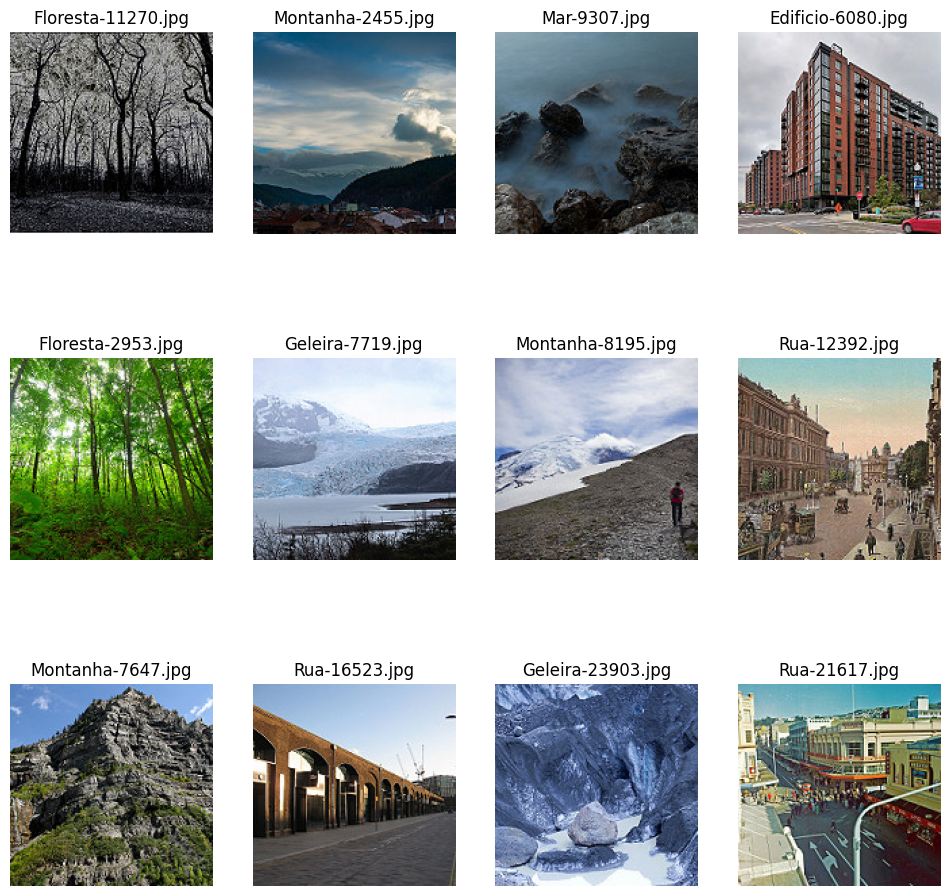

In [75]:
fig = plt.gcf()
fig.set_size_inches(3*4, 3*4)

# Visualizando 12 imagens
for i in range(12):

    sample = np.random.choice(images)
    for j in range(0,len(df)):
      if df['image_name'][j]==sample:
        titulo=df['label'][j]
        img_path =imagePath+sample
        sp = plt.subplot(3, 4, i + 1)
        sp.axis('Off')
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(titulo+"-"+df['image_name'][j])

plt.show()

## Seção II: Passos iniciais para tratamento dos dados

### Acessando e tratando os dados que serão a entrada do modelo de deep learning

In [76]:
# Definindo o tamanho do batch e dimensão das imagens e a quantidade de épocas
batch_size = 32
img_height = 224
img_width = 224
num_classes = 6
epochs = 2

In [77]:
# Associando as imagens ao dataset de treino
for i in com_label.index:
    nameOfFile = com_label['image_name'][i]
    if os.path.exists(imagePath+nameOfFile):
        image = mpimg.imread(imagePath+nameOfFile)
        if (len(image.shape)!=3): # Verify if the image is correct
            print("A imagem N°",i,' : ',nameOfFile," não está adequada")
        else :
            image = cv2.resize(image,(img_width,img_height)) # conjunto de arquivos com label sem imagens "expúrias"
            arquivos_com_label.append(image)
            labels.append(com_label['label'][i])
print(len(arquivos_com_label))
print(len(labels))

17034
17034


In [78]:
labels[0]

'Edificio'

In [79]:
# Convertendo o dataset de treino em array
arquivos_com_label = np.array(arquivos_com_label)
labels = np.array(labels)
print(arquivos_com_label.shape,labels.shape)

(17034, 224, 224, 3) (17034,)


### Reavaliar esta parte

In [ ]:
# Definindo os caminhos de diretorios de treino, validação e teste
train_dir = '/content/scene/treino'
val_dir = '/content/scene/validacao'
test_dir = '/content/scene/teste'
treinamento_modelos_dir='/content/scene/trained_models'
if not os.path.exists(train_dir):
  os.makedirs(train_dir)
if not os.path.exists(val_dir):
  os.makedirs(val_dir)
if not os.path.exists(test_dir):
  os.makedirs(test_dir)
if not os.path.exists(treinamento_modelos_dir):
  os.makedirs(treinamento_modelos_dir)

## Seção III: Configuração do Modelo de Deep Learning

### Configuração do Modelo usando uma Rede Neural Convolucional (CNN) Simples

Utilizando a biblioteca Keras, será especificada uma camada convolucional 2D com 32 filtros (depois 64, 128 e 256) e função de ativação do tipo ReLU. Na sequência é adicionada uma camada softmax com o mesmo tipo de função de ativação.

In [80]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 3, activation='relu', padding= "same", input_shape=(img_height,img_width,3)),
    keras.layers.MaxPooling2D((2)),
    keras.layers.Conv2D(128, 3, activation='relu', padding= "same"),
    keras.layers.Conv2D(128, 3, activation='relu', padding= "same"),
    keras.layers.MaxPooling2D((2)),
    keras.layers.Conv2D(256, 3, activation='relu', padding= "same"),
    keras.layers.Conv2D(256, 3, activation='relu', padding= "same"),
    keras.layers.Conv2D(256, 3, activation='relu', padding= "same"),
    keras.layers.MaxPooling2D((2)),
    keras.layers.Conv2D(512, 3, activation='relu', padding= "same"),
    keras.layers.Conv2D(512, 3, activation='relu', padding= "same"),
    keras.layers.Conv2D(512, 3, activation='relu', padding= "same"),
    keras.layers.MaxPooling2D((2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [81]:
# Resumindo o modelo que será utilizado
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       2

### Treinamento do modelo de deep learning

Vamos considerar o modelo Adam para otimização. Como métrica para avaliação do modelo, será usado o critério de acurácia. Além disso, por se tratar de um problema de classificação com mais de 2 categorias (6, neste problema), a perda considerada será do tipo entropia cruzada.

In [82]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

### Separação das imagens com labels fornecidos em treino e validação
As imagens com categorias fornecidas conforme DataFrame treino serão divididas em treino de fato e validação

In [89]:
# Separação do dataset com os labels em treino e teste (20% para teste)
X_train, X_test, y_train, y_test = train_test_split(df['image_name'], df['label'], test_size=0.2 ,random_state=42 , shuffle=True)

# Redivisão do dataset de treino em treino (90%) e validação (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42 , shuffle=True)

In [90]:
# Avaliando os comprimentos dos datasets de treino e validação
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape)
print(X_train.dtype,y_train.dtype,X_test.dtype,y_test.dtype, X_val.dtype,y_val.dtype)

(12264,) (12264,) (3407,) (3407,) (1363,) (1363,)
object object object object object object


In [ ]:
dfX_train=pd.DataFrame(X_train)
dfX_test=pd.DataFrame(X_test)
dfX_val=pd.DataFrame(X_val)

# Resetando o índice original
dfX_train=dfX_train.reset_index()
dfX_test=dfX_test.reset_index()
dfX_val=dfX_val.reset_index()

# Deletando a coluna index com os índices originais
dfX_train=dfX_train.drop(columns=["index"])
dfX_test=dfX_test.drop(columns=["index"])
dfX_val=dfX_val.drop(columns=["index"])

In [127]:
dfX_train.head()

,image_name
0,8848.jpg
1,4082.jpg
2,5709.jpg
3,3880.jpg
4,22585.jpg


In [120]:
df_train=[]
df_test=[]
df_val=[]

for j in range(len(df)):
  for k in range(len(dfX_train)):
    if df['image_name'][j]==dfX_train['image_name'][k]:
      df_train=df_train.append(df[j,:])

KeyError: ignored

In [104]:
dfX_train.head()

,image_name
8101,8848.jpg
6091,4082.jpg
15403,5709.jpg
1203,3880.jpg
1110,22585.jpg


In [105]:
dfy_train=pd.DataFrame(y_train)
dfy_train.head()

,label
8101,Rua
6091,Edificio
15403,Mar
1203,Geleira
1110,Mar


In [111]:
df_train=dfX_train.append(dfy_train)
df_train.head

<bound method NDFrame.head of       image_name     label
8101    8848.jpg       NaN
6091    4082.jpg       NaN
15403   5709.jpg       NaN
1203    3880.jpg       NaN
1110   22585.jpg       NaN
...          ...       ...
15904        NaN  Montanha
2869         NaN  Floresta
2083         NaN   Geleira
11901        NaN       Mar
10530        NaN   Geleira

[24528 rows x 2 columns]>

In [91]:
# Confirmando que os datasets possuem quantidades representativas de cada uma das seis categorias
unique, counts = np.unique(y_train, return_counts=True)
print('Distribuição quantitativa dos labels no dataset de treino:')
print(dict(zip(unique, counts)))
print('---------------------------------------------------------------------------')
unique, counts = np.unique(y_test, return_counts=True)
print('Distribuição quantitativa dos labels no dataset de teste:')
print(dict(zip(unique, counts)))
print('---------------------------------------------------------------------------')
unique, counts = np.unique(y_val, return_counts=True)
print('Distribuição quantitativa dos labels no dataset de validação:')
print(dict(zip(unique, counts)))

Distribuição quantitativa dos labels no dataset de treino:
{'Edificio': 1890, 'Floresta': 1971, 'Geleira': 2117, 'Mar': 2003, 'Montanha': 2183, 'Rua': 2100}
---------------------------------------------------------------------------
Distribuição quantitativa dos labels no dataset de teste:
{'Edificio': 535, 'Floresta': 551, 'Geleira': 590, 'Mar': 559, 'Montanha': 623, 'Rua': 549}
---------------------------------------------------------------------------
Distribuição quantitativa dos labels no dataset de validação:
{'Edificio': 203, 'Floresta': 223, 'Geleira': 250, 'Mar': 222, 'Montanha': 231, 'Rua': 234}


Após a divisão, os datasets de treino, teste e validação ficaram com distribuições significativas de todas as 6 categorias de imagem.

## Avaliar em 21/07

In [92]:
ntrain = X_train.shape[0]
nval = X_val.shape[0]
ntest = X_test.shape[0]

In [ ]:
train_generator=train_datagen.flow_from_dataframe(
    train ,path,
    target_size=(150,150),
    batch_size=50,
    class_mode='binary',
    x_col='images',
    y_col='class',
    subset='training' #training set
    )

val_generator=train_datagen.flow_from_dataframe(
    train ,path,
    target_size=(150,150),
    batch_size=50,
    class_mode='binary',
    x_col='images',
    y_col='class',
    subset='validation' #validation set
    )

test_generator=test_datagen.flow_from_dataframe(
    test ,path,
    target_size=(150,150),
    batch_size=50,
    class_mode='binary',
    x_col='images',
    y_col='class',)

### Preparação dos dados
Será utilizada a classe "ImageDataGenerator", do TensorFlow, destinada a aumentar e pré-processar dados de imagem em tarefas de Aprendizado Profundo.

In [93]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

No presente trabalho, será usado o método flow_from_dataframe() para gerar imagens aumentadas a partir de um dataframe, que aponta para as imagens originais. O método recebe parâmetros como o dataframe, o diretório com as imagens, o tamanho do lote (batch size) e o modo de classe (neste caso, sparse, em função da quantidade de classes), entre outros.

Importante ressaltar que o pré-processamento do teste não evolve o aumento de dados.

In [95]:
# Criação dos data generators
train_generator = train_datagen.flow(X_train, y_train,batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val,batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test,batch_size=batch_size)

ValueError: ignored

In [ ]:
history = model.fit(train_generator, steps_per_epoch=ntrain//batch_size,epochs=epochs)

Epoch 1/30
479/479 [==============================] - 200s 370ms/step - loss: 1.6808 - accuracy: 0.2873 - val_loss: 1.4298 - val_accuracy: 0.4163
Epoch 2/30
479/479 [==============================] - 181s 377ms/step - loss: 1.4615 - accuracy: 0.4046 - val_loss: 1.2525 - val_accuracy: 0.5371
Epoch 3/30
479/479 [==============================] - 180s 374ms/step - loss: 1.3341 - accuracy: 0.4690 - val_loss: 1.1244 - val_accuracy: 0.6020
Epoch 4/30
479/479 [==============================] - 177s 368ms/step - loss: 1.2415 - accuracy: 0.5149 - val_loss: 0.9512 - val_accuracy: 0.6680
Epoch 5/30
479/479 [==============================] - 179s 373ms/step - loss: 1.1421 - accuracy: 0.5553 - val_loss: 0.8252 - val_accuracy: 0.7134
Epoch 6/30
479/479 [==============================] - 179s 373ms/step - loss: 1.0795 - accuracy: 0.5906 - val_loss: 0.8618 - val_accuracy: 0.6798
Epoch 7/30
479/479 [==============================] - 181s 378ms/step - loss: 1.0005 - accuracy: 0.6291 - val_loss: 0.7383 -

## Seção IV: Execução do Modelo de Deep Learning
Nesta seção, o modelo treinado será aplicado em cada uma das imagens do dataset de teste, indicando a qual das 6 classes  (Edificio; Floresta; Montanha; Geleira; Rua; Mar) pertence.

##CONTINUAR DAQUI EM 21/07

In [ ]:
parent_dir = '../content/scene/teste'
count_images = 0
class_names = ['Edificio',
               'Floresta',
               'Montanha',
               'Geleira',
               'Rua',
               'Mar']
y_pred = list()
y_true = list()

In [ ]:
# Associando as imagens ao dataset de teste
# As imagens do dataset de teste contêm apenas o nome. Os labels (categorias de paisagem) serão preditos pelo modelo
for i in teste.index:
    nameOfFile = teste['image_name'][i]
    if os.path.exists(imagePath+nameOfFile):
        image = mpimg.imread(imagePath+nameOfFile)
        if (len(image.shape)!=3):
            print("A imagem N°",i,' : ',nameOfFile," não está adequada")
        else :
            image = cv2.resize(image,(img_width,img_height)) # conjunto de teste sem imagens "expúrias"
            # Previsão
            prediction = model.predict(image)
            arquivos_teste_prediction.append(prediction)
            arquivos_teste.append(image)
print(len(arquivos_teste))
print(len(arquivos_teste_prediction))

In [ ]:
# Percorrendo a pasta onde estão salvas as imagens de teste (dividida em diretórios, subdiretórios e arquivos)

for subdir, dirs, files in os.walk(parent_dir):
  for file in files:
    if file.endswith('.png') or file.endswith('.jpg'):  # Considerando que as imagens são de extensão .png ou .jpg
#
      count_images+=1
      split_path = os.path.join(subdir, file).split('/')
      label = split_path[3]
      y_true.append(label)
      img_path = os.path.join(subdir, file)
      display(Image(filename=img_path, width=300))
      img = image.load_img(img_path, target_size=(img_height, img_width))
      figura = image.img_to_array(img)
      figura = np.expand_dims(figura, axis=0)
      figura = figura.astype('float32') / 255.0
#
      # Previsão
      prediction = model.predict(figura)
#
      # Printando as saídas do modelo
      predicted_class = np.argmax(prediction[0])
      probability = prediction[0][predicted_class]
      y_pred.append(class_names[predicted_class])
      print("Categoria Real:", label)
      print("Categoria Prevista:", class_names[predicted_class])
      print("Probabilidade indicada para a categoria prevista:", probability)
      print("\n")

## Seção V: Avaliação do Modelo



In [ ]:
# Calculando as métricas para avaliação do modelo
acuracia = skm.accuracy_score(y_true, y_pred)
precisao = skm.precision_score(y_true, y_pred, average='weighted')
recall = skm.recall_score(y_true, y_pred, average='weighted')
f1score = skm.f1_score(y_true, y_pred, average='weighted')

print("Acurácia: ", acuracia)
print("Precisão: ", precisao)
print("Recall: ", recall)
print("F-Score: ", f1score)

### Matriz de Confusão

In [ ]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
np.set_printoptions(precisao=2)

plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=['Edificio',
                               'Floresta',
                               'Montanha',
                               'Geleira',
                               'Rua',
                               'Mar'],
                      normalize= False,
                      title='Matriz real x predição')

### Exportação do Modelo

In [ ]:
# Vamos salvar o modelo treinado para aplicação futura

# obtendo a data e hora atual
now = datetime.now()

# Definição do formato
format = '%Y-%m-%dT%H%M'

# Converter a data e hora em uma string com o formato especificado
formatted_datetime = now.strftime(format)

path_model = treinamento_modelos_dir

name_model = 'trained_model_' + formatted_datetime + '.h5'

# salvando o modelo
model.save("%s/%s" % (path_model, name_model))
print("Modelo salvo com o nome: ", name_model)